# Collaboration and Competition

---

This notebook has been prepared for Udacity's Deep Reinforcement Learning Nanodegree. Please take a look at the README file in the repo for details regarding setting up the environment.

### 1. Start the Environment


In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque

from agent import DoubleCoopAgent, Agent


Device: cpu


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="../Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 


In [4]:
RANDOM_SEED = 42
BASELINE_SCORE = 0.5

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

Just to demo the environment by taking some random actions

In [5]:
num_episodes = 1

for i in range(1, num_episodes + 1):                       # play game for a number of episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0


### 4. Initialize Agent object

In [6]:
agent = DoubleCoopAgent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)


Actor network...
 Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

Critic network...
 Critic(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcs1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


### 5. Training the agent

Now let's train the agent using a multi agent version of the DDPG algorithm.

In [7]:
WARMER_LIMIT = 100

def train_agents(n_episodes=5000, max_t=2500, print_every=100, noise_decay_factor=0.999, noise_wt_min=0.1):
    print("\nStarting to train the agent....\n")

    rolling_scores = deque(maxlen=print_every)
    scores = []
    noise_wt = 1.0
    max_score = 0.0

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        agent_scores = np.zeros(len(env_info.agents))

        for t in range(max_t):
            if i_episode < WARMER_LIMIT:
                actions = np.random.randn(num_agents, action_size)
            else:
                actions = agent.act(states, weight=noise_wt)
            env_info = env.step(actions)[brain_name]

            rewards = env_info.rewards
            next_states = env_info.vector_observations
            is_dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, is_dones)
            states = next_states
            agent_scores += rewards
            if np.any(is_dones):
                break

        avg_agent_score = np.mean(agent_scores)
        max_score = max(max_score, avg_agent_score)
        rolling_scores.append(avg_agent_score)
        scores.append(avg_agent_score)
        
        if i_episode >= WARMER_LIMIT:
            noise_wt = max(noise_decay_factor * noise_wt, noise_wt_min)

        rolling_mean_score = np.mean(rolling_scores)

        print('\rEpisode {}\tEpisode Score: {:.3f}\t'
              'Noise Factor: {:.2f}\tMax Score: {:.3f}\t'
              'Average Score: {:.2f}'.format(i_episode, avg_agent_score, noise_wt,
                                             max_score, rolling_mean_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tEpisode Score: {:.3f}\t'
                  'Noise Factor: {:.2f}\tMax Score: {:.3f}\t'
                  'Average Score: {:.2f}'.format(i_episode, avg_agent_score, noise_wt,
                                             max_score, rolling_mean_score), end="")

        if rolling_mean_score >= BASELINE_SCORE:
            print('\nEnvironment solved in {:d} Episodes \t'
                  'Average Score: {:.2f}'.format(i_episode, rolling_mean_score))
            torch.save(agent.actor_local.state_dict(), '../weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), '../weights/checkpoint_critic.pth')
            break

    return scores

scores = train_agents()
env.close()


Starting to train the agent....

Episode 994	Episode Score: 2.600	Noise Factor: 0.41	Max Score: 2.650	Average Score: 0.5290
Environment solved in 994 Episodes 	Average Score: 0.52


### 6. Plot rewards

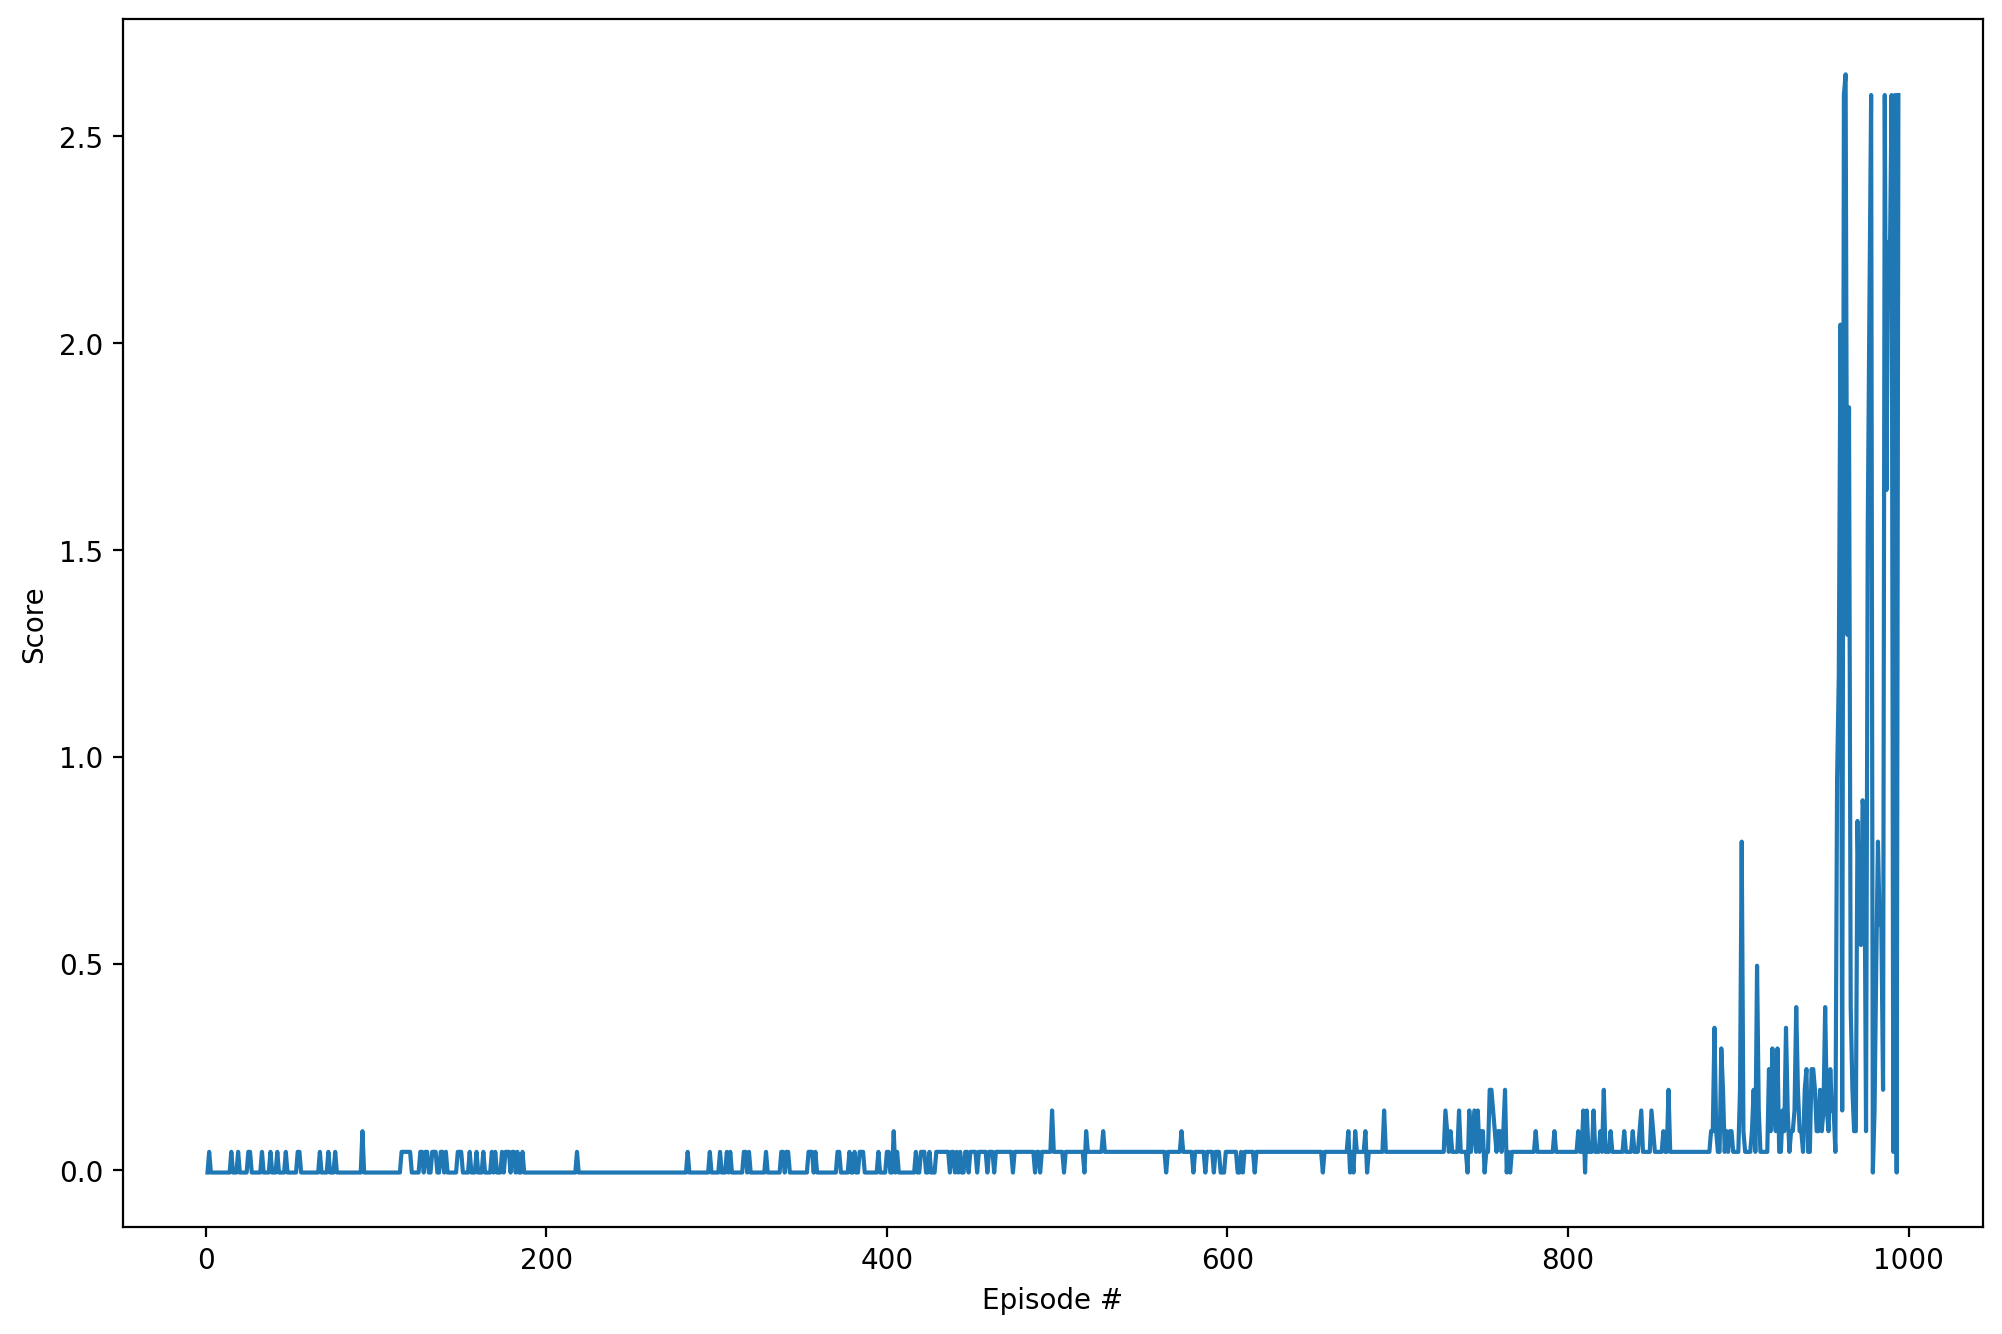

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200


def plot_rewards(scores_):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores_) + 1), scores_)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()
    
plot_rewards(scores)